<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S12_ImageCaption_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Mon May 17 14:55:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Reference : https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning
This notebook is based on above reference. Code below is heavily commented at each line. This code is built with a focus on deploying to cloud thereby addressing space limitations of models.Encoder is using pre-trained RESNET-18.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install torch==1.5.0+cu92 torchvision==0.6.0+cu92 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 114kB/s 
     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 17.7MB/s 
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [4]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 100kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [5]:
import zipfile
from zipfile import ZipFile
from time import time
from datetime import datetime 
import torch
import torchvision
from torchvision import transforms
import torch.utils.data
import torchvision.utils as utils
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
import os
import numpy as np
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.0+cu92


In [6]:
!unzip -q '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/Flickr8k_Dataset.zip'
!unzip -q '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/Flickr8k_text.zip'
!unzip -q '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/caption_datasets.zip'

In [7]:
import h5py
import json
from scipy.misc import imread, imresize
from collections import Counter
from random import seed, choice, sample

def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,
                       max_len=100):
    """
    Creates input files for training, validation, and test data.
    :param dataset: name of dataset, one of 'coco', 'flickr8k', 'flickr30k'
    :param karpathy_json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param captions_per_image: number of captions to sample per image
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    """

    """
    Sample format of flickr8k json file is as follows:
    {"images": [{"sentids": [0, 1, 2, 3, 4], 
     "imgid": 0, "sentences": [{"tokens": ["a", "black", "dog", "is", "running", "after", "a", "white", "dog", "in", "the", "snow"], "raw": "A black dog is running after a white dog in the snow .", "imgid": 0, "sentid": 0}, 
                               {"tokens": ["black", "dog", "chasing", "brown", "dog", "through", "snow"], "raw": "Black dog chasing brown dog through snow", "imgid": 0, "sentid": 1}, 
						                   {"tokens": ["two", "dogs", "chase", "each", "other", "across", "the", "snowy", "ground"], "raw": "Two dogs chase each other across the snowy ground .", "imgid": 0, "sentid": 2}, 
						                   {"tokens": ["two", "dogs", "play", "together", "in", "the", "snow"], "raw": "Two dogs play together in the snow .", "imgid": 0, "sentid": 3}, 
						                   {"tokens": ["two", "dogs", "running", "through", "a", "low", "lying", "body", "of", "water"], "raw": "Two dogs running through a low lying body of water .", "imgid": 0, "sentid": 4}], 
						                    "split": "train", "filename": "2513260012_03d33305cf.jpg"}, 
                {"sentids": [5, 6, 7, 8, 9], 
     "imgid": 1, "sentences": [{"tokens": ["a", "little", "baby", "plays", "croquet"], "raw": "A little baby plays croquet .", "imgid": 1, "sentid": 5},
                               {"tokens": ["a", "little", "girl", "plays", "croquet", "next", "to", "a", "truck"], "raw": "A little girl plays croquet next to a truck .", "imgid": 1, "sentid": 6},
                               {"tokens": ["the", "child", "is", "playing", "croquette", "by", "the", "truck"], "raw": "The child is playing croquette by the truck .", "imgid": 1, "sentid": 7}, 
                               {"tokens": ["the", "kid", "is", "in", "front", "of", "a", "car", "with", "a", "put", "and", "a", "ball"], "raw": "The kid is in front of a car with a put and a ball .", "imgid": 1, "sentid": 8}, 
                               {"tokens": ["the", "little", "boy", "is", "playing", "with", "a", "croquet", "hammer", "and", "ball", "beside", "the", "car"], "raw": "The little boy is playing with a croquet hammer and ball beside the car .", "imgid": 1, "sentid": 9}],
                                "split": "train", "filename": "2903617548_d3e38d7f88.jpg"}			
    """                      

    assert dataset in {'coco', 'flickr8k', 'flickr30k'}

    # Read Karpathy JSON
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)

    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()   # list1 = ['x','y','z','x','x','x','y', 'z']. The output if counter is used on list1 should be something like :
                            # Counter({'x': 4, 'y': 2, 'z': 2})

    for img in data['images']:
        captions = []
        for c in img['sentences']:
            # Update word frequency
            word_freq.update(c['tokens'])
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])      

        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(
            image_folder, img['filename'])
        
        if img['split'] in {'train', 'restval'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)

    print ('# of train_images, val_images, test_images : ', len(train_image_paths), len(val_image_paths), len(test_image_paths)) 
    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq] # words occuring less frequently than min_word_freq are binned as <unk>s
    word_map = {k: v + 1 for v, k in enumerate(words)} # v+1 to reserve first index 0 for <pad>. word_map is a dict like {<pad>:0, 'a':1, 'an':2,..}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    # Create a base/root name for all output files
    base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'
    print('base_filename : ', base_filename)

    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    
    # Sample captions for each image, save images to HDF5 file, and captions and their lengths to JSON files
    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:

        print(' *** Split Change *** :', split)
        cnt = 0
        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            # Make a note of the number of captions we are sampling per image
            h.attrs['captions_per_image'] = captions_per_image

            # Create dataset inside HDF5 file to store images
            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []
            
            for i, path in enumerate(tqdm(impaths)):
                cnt +=1 
                # Sample captions
                if len(imcaps[i]) < captions_per_image:
     
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]  
                    # choice() returns a random item. mylist = ["apple", "banana", "cherry"], print(choice(mylist)) --> banana
                    # We are filling the gap between captions_per_image and length of caption by available words randomly chosen from that specific caption itself
                    # Let us say len(imcaps[i]) = 3 & captions_per_image = 5, then 4th & 5th captions will be generated by above logic
                else:                    
                    captions = sample(imcaps[i], k=captions_per_image) 
                    # Prints list of random items of given length. list1 = [1, 2, 3, 4, 5] , print(sample(list1,3))  --> [2,3,5]
                    # If len(imcaps[i]) = 5 and captions_per_image = 5, then all 5 captions will be written
                    # If len(imcaps[i]) = 7 and captions_per_image = 5, then 5 captions out of 7 will be randomly chosen via random() and written

                # Sanity check
                assert len(captions) == captions_per_image

                # Read images
                img = imread(impaths[i])
                if len(img.shape) == 2:           # If gray scale, add 1 more axis to bring to [256, 256, 3] format
                    img = img[:, :, np.newaxis]   # An empty axis created on 3rd dimension i.e. axis = 2 (0 & 1 are existing axes)
                    img = np.concatenate([img, img, img], axis=2)  # Filling values of 0 & 1 axis (2d frame), three times to make it 3D
                                                                   # eg: (256, 256) is filled 3 times to give RGB i.e. (256, 256, 3) 
                img = imresize(img, (256, 256))   # eg: (128, 128, 3) -> (256, 256, 3)
                img = img.transpose(2, 0, 1)      # changes (256,256,3) to (3, 256, 256)
                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255

                # Save image to HDF5 file
                images[i] = img

                for j, c in enumerate(captions):
                    # Encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))
                    # Create encoding for each caption. Use index of <unk> if a particular word from caption is not found in word_map.
                    # Pad the vacant space with index belonging to <pad>
                    # If max_len we are passing as argument is 50 & caption length from dataset is 14, then 50-14 = 36 will be padded as <pad>

                    # Find caption lengths
                    c_len = len(c) + 2   # Plus 2 as we are adding <start> and <end> indexes

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)
            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)

In [8]:
#### MANUALLY Create a folder '/content/data_output' before executing this cell

create_input_files(dataset='flickr8k',
                       karpathy_json_path='/content/dataset_flickr8k.json',
                       image_folder='/content/Flicker8k_Dataset/',
                       captions_per_image=5,
                       min_word_freq=5,
                       output_folder='/content/data_output/',
                       max_len=50)

  0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  0%|          | 7/6000 [00:00<01:29, 66.92it/s]

# of train_images, val_images, test_images :  6000 1000 1000
base_filename :  flickr8k_5_cap_per_img_5_min_word_freq
 *** Split Change *** : TRAIN

Reading TRAIN images and captions, storing to file...



  1%|          | 11/1000 [00:00<00:09, 106.61it/s]

 *** Split Change *** : VAL

Reading VAL images and captions, storing to file...



  1%|          | 12/1000 [00:00<00:08, 116.86it/s]

 *** Split Change *** : TEST

Reading TEST images and captions, storing to file...



100%|██████████| 1000/1000 [00:09<00:00, 109.77it/s]


In [9]:
class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']  ## If there are 5 different captions for an image, then cpi = 5

        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        # i indicates captions..For every image there are 5 captions (cpi)...so total images = i / self.cpi
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            # eg: all_captions belonging to 2nd image.
            # Here i will be 5,6,7,8,9 (assuming index starts at 0). Let us take i = 8
            # so [((8//5)*5):(((8//5)*5) + 5)]  = [(1*5):((1*5)+5)] = [5:10] ie return all captions with idx 5,6,7,8,9 for 2nd image
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size

In [21]:
def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.
    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)

'''
def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map (word map is what we get based on captions dataset)
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim
'''

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename    = 'checkpoint_' + data_name + '.pth.tar'
    #pt_filename = 'checkpoint_' + data_name + '.pt'
    
    '''
    In PyTorch, the learnable parameters (i.e. weights and biases) of a torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). 
    A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.
    '''
    torch.save(state, filename)       
    #torch.save({
    #            "encoder": encoder.state_dict(),
    #            "decoder": decoder.state_dict()
    #           }, pt_filename)
    
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    print('epoch :', epoch, 'Checkpoint saved :', filename)
    if is_best:
        torch.save(state, 'BEST_' + filename)
        #torch.save({
        #        "encoder": encoder.state_dict(),
        #        "decoder": decoder.state_dict()
        #           }, 'BEST_' + pt_filename)  
        print('Best checkpoint encountered & saved in epoch :', epoch)      


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric. This class is used for below objects while training & validating:
    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

#### Necessary imports for training

In [11]:
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
#from models import Encoder, DecoderWithAttention
#from datasets import *
#from utils import *
from nltk.translate.bleu_score import corpus_bleu

In [12]:
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet18(pretrained=True)  # pretrained ImageNet ResNet-18

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
                 
        '''
        nn.Sequential is a construction which is used when you want to run certain layers sequentially.
        Let us say modules = [layer1,layer2,layer3]
        x = ... # our input

        x = layer1(x)
        x = layer2(x)
        x = layer3(x)
        '''
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048) -> (32, 14, 14, 2048)
        #print('Encoder Ouput size:', out.size())
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [13]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim) [32, 196, 2048]
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim) [32, 512]
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim) 
                                              # [32, 196, 2048] -> [32, 196, 512] makes encoder_out compatible with attention_dim via nn.linear
                                              # for t = 17, batch_size_t = 3 in example, [3, 196, 2048] -> [3, 196, 512]
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
                                                 # for t = 17, batch_size_t = 3 in example, [3, 512] -> [3, 512] as both attention_dim & decoder_dim = 512
        att_temp0 = self.relu(att1 + att2.unsqueeze(1))         

        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        # for t = 17,  batch_size_t = 3 in example,
        #   att2.unsqueeze(1)                                             --> Adding dimension to make [3, 512] --> [3, 1, 512]
        #   self.relu(att1 + att2.unsqueeze(1))                           --> [3, 196, 512] + [3, 1, 512] -> [3, 196, 512]
        #   self.full_att(self.relu(att1 + att2.unsqueeze(1)))            --> [3, 196, 512] -> [3, 196, 1]
        #   self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) --> Removing dim =2 to give [3, 196]
        
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        # for t = 17,  batch_size_t = 3 in example,
        #    alpha = self.softmax(att)                       --> [3, 196]. These are weights to be multiplied with encodings to give attention.
        #    alpha.unsqueeze(2)                              --> [3, 196, 1]. Adding dimension on dim =2 to enable multiplication with encodings.
        #    encoder_out                                     --> [3, 196, 2048]
        #    (encoder_out * alpha.unsqueeze(2))              --> [3, 196, 2048]. Multipled alpha. Equilant to multiplying a scalar weight.
        #    (encoder_out * alpha.unsqueeze(2)).sum(dim=1)   --> Sums up 196 pixels in dim = 1 to give [3, 2048] 

        return attention_weighted_encoding, alpha

In [14]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1) # will take mean of [32, 196, 2048] against dim=1 giving mean_encoder_out of size [32, 2048]
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        # An example how nn.linear works
        # >>> m = nn.Linear(20, 30) --> Here self.init_h = nn.Linear(encoder_dim, decoder_dim) where encoder_dim = 2048 & decoder_dim = 512
        # >>> input = torch.randn(128, 20)
        # >>> output = m(input)     --> Here h = self.init_h(mean_encoder_out) --> we will get h of size [32, 512] i.e. 2048 converted to 512 for batch-size of 32 
        # >>> print(output.size())
        # torch.Size([128, 30])

        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        batch_size = encoder_out.size(0)  # torch.Size([32, 14, 14, 2048])...batch_size 32
        encoder_dim = encoder_out.size(-1) # encoder_dim = 2048..last dimension of encoder_out
        vocab_size = self.vocab_size
       
        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim) -> (32, 196, 2048)
        # enoder_out size is [32, 14, 14, 2048]. While using encoder_out.view, we kept batch_size =32 & encoder_dim = 2048 as such and
        # gave -1 inplace of 14, 14. So pytorch converts this -1 to 14*14 = 196 which is num_pixels
        # We are converting encoder output to this format because we need to know which pixel/s out of 196 to focus using attention mechanism
        num_pixels = encoder_out.size(1) # 196 pixels (14*14)

        # Sort input data by decreasing lengths; why? apparent below
        # torch.sort will give 2 outputs 
        # A namedtuple of (values, indices) is returned, where the values are the sorted values and indices are the indices of the elements 
        # in the original input tensor. Here values -> caption_lengths, indices -> sort_ind
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True) # caption_lengths.size() -> 32 , sort_ind.size() -> 32
        encoder_out = encoder_out[sort_ind]  # Sorting corresponding input image encodings based on sorted indices [32, 196, 2048]
        encoded_captions = encoded_captions[sort_ind] # Sorting corresponding input caption encodings based on sorted indices [32, 52]
                                                      # [32, 52] because 32 is batch size and 52 is the fixed caption length we choose to create above in input dataset.

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim) --> [32, 52, 512]

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim) --> h & c of size [32, 512]

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        # Let us say caption_lengths are tensor([20, 19, 19, 18, 16, 15, 14, 14, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10,  9,  9,  9,  8,  8,  8,  7],
        # then decode_lengths will be           [19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10,  9,  9,  9,  8,  8,  8,  7,  7,  7,  6]
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device) 
        # predictions are words --> an instance could be [32, 19, 2633]. Here 19 can change based on max caption_length in a particular batch.
        # vocab_size -> 2633 -> len(word_map). Word_map we created early while creating input data 

        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device) 
        # alphas are weights that decide which pixel to focus
        # an instance could be [32, 19, 196]. Here 19 can change based on max caption_length in a particular batch.


        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        
        # This 'for' loop is to ensure that we process images by decreasing caption lengths. This will help to avoid processing <pad>.
        # Let us say decode_lengths = [19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 8, 8, 8, 7, 7, 7, 6]
        # Here max(decode_lengths) = 19 so 'for' loop will execute from 0 to 18 & batch_size_t at each time-step 't' will be as follows:
        '''
        batch_size_t = sum([l > t for l in decode_lengths])
        t = 0 till 5 , batch_size_t = 32, all 32 images processed & 32 outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 8, 8, 8, 7, 7, 7, 6
        t = 6, batch_size_t = 31, only 31 images processed & 31 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 8, 8, 8, 7, 7, 7
        t = 7, batch_size_t = 28, only 28 images processed & 23 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 8, 8, 8
        t = 8, batch_size_t = 25, only 25 images processed & 25 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9
        t = 9, batch_size_t = 22, only 22 images processed & 22 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10
        t = 10, batch_size_t = 19, only 19 images processed & 19 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11
        t = 11, batch_size_t = 15, only 15 images processed & 15 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12
        t = 12, batch_size_t = 8, only 8 images processed & 8 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14, 13
        t = 13, batch_size_t = 6, only 6 images processed & 6 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15, 14
        t = 14, batch_size_t = 5, only 5 images processed & 5 top outputs from previous step is used. Caption_length 19, 18, 18, 17, 15
        t = 15, batch_size_t = 4, only 4 images processed & 4 top outputs from previous step is used. Caption_length 19, 18, 18, 17
        t = 16, batch_size_t = 4, only 4 images processed & 4 top outputs from previous step is used. Caption_length 19, 18, 18, 17
        t = 17, batch_size_t = 3, only 3 images processed & 3 top outputs from previous step is used. Caption_length 19, 18, 18
        t = 18, batch_size_t = 1, only 1 image processed & 1 top output from previous step is used. Caption_length 19
        '''
        for t in range(max(decode_lengths)):
            
            batch_size_t = sum([l > t for l in decode_lengths])
          
            '''
                        attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t], px) 
            Passing only those image encodings to attention network based on decreasing caption lengths
            for example at t = 16, batch_size_t = 4 
                           t = 17, batch_size_t = 3. Let us consider 17th time-step.
            then encoder_out[:3] which means only 3 images out of 32 that are passed to attention on 17th step Which also means out of 
            [32, 196, 2048] only [3,196,2048] is passed to self.attention.
            Also h[:3] means only first 3 entries from h belonging to 16th time-step will be passed on 17th step for attention processing.
            which means out of [32, 512], only [3,512] is passed to self.attention
            '''
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t]) 
            
            # for t = 17 in above example, attention_weighted_encoding.size() will be [3, 2048] and alpha will be [3, 196]
            # Check Attention(nn.module) to get better sense of dimensions and operation

            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim) 
                            # for t = 17 in above example, 
                            # h[:batch_size_t]                             --> [3, 512], h --> [4, 512] bcoz t = 16 has batch_size_t = 4  
                            # self.f_beta(h[:batch_size_t])                --> [3, 2048]
                            # self.sigmoid(self.f_beta(h[:batch_size_t]))  --> [3, 2048]
                            # This dimension change is to enable gating scalar multiplication with attention_weighted_encoding [3, 2048]
            attention_weighted_encoding = gate * attention_weighted_encoding  # for t =17 in above example, [3, 2048]      
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            '''
            for t = 17 in above example, 
               [embeddings[:batch_size_t, t, :] --> embeddings[:3, 17, :] --> [3, 512] where embeddings.size() is [32, 52, 512]
               Refer pytorch slicing example given below for more clarity
               :3        -> 0,1,2 out of 32 selected from [32,52,512]
               17        -> Only 17th row out of 52 rows selected from [32,52,512]
               :         -> All 512 columns selected from [32,52,512]
               17, :     -> 17th row element for all 512 columns selected. This will give a tensor of size [1, 512]
               :3, 17, : -> Means 3 such entries out of 32 is selected giving a tensor of size [3, 512]
               torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
                                                --> torch.cat([[3, 512], [3, 2048]], dim =1) --> [3, 2560]
               h[:batch_size_t] that is fed to LSTM will be from t = 16. So h.size() will be [4, 512] bcoz t = 16 has batch_size_t = 4 &
               h passed to LSTM in 17th time-step i.e. h[:batch_size_t] will be [3, 512] bcoz t = 17 has batch_size_t = 3.
               
               Similarly c[:batch_size_t] that is fed to LSTM will be from t = 16. So c.size() will be [4, 512] bcoz t = 16 has 
               batch_size_t = 4 & c passed to LSTM  in 17th time-step i.e. c[:batch_size_t] will be [3, 512] bcoz t = 17 has batch_size_t = 3.
               
               To summarize h,c = self.decode_step([3,2560], [3, 512], [3, 512])

               self.decode_step is an LSTM cell that will accept weighted encodings, prev prediction from decoder (h) and prev cell state (c).
               Output of LSTM cell is h and c.

            '''   
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size) 
            # preds are scores over vocabulary. 
            # for t = 17 in above example, h.size = [3, 512]. After passing through self.fc it will become [3, 2633]     
            predictions[:batch_size_t, t, :] = preds
            # Here predictions.size() that we created before 'for' loop is [32, 19, 2633]. 
            # Out of this [0:3, 19, 2633] is replaced by preds we got above
            alphas[:batch_size_t, t, :] = alpha
            # Here alphas.size() that we created before 'for' loop is [32, 19, 196]. 
            # Out of this [0:2, 19, 196] is replaced by alpha we got from self.attention           
       
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [15]:
# Data parameters
data_folder = '/content/data_output'                  # folder with data files saved by create_input_files.py...Create this MANUALLY in colab
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'  # base name shared by data files

In [16]:
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
encoder_dim = 512 # dimension from the resnet18
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [17]:
# Training parameters
start_epoch = 0
epochs = 50  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

In [18]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """  

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    print(' *** Epoch :',epoch)    

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)
        # Output of decoder -> predictions [32, 20, 2633], encoded_captions [32,52], decode_lengths 32, alphas [32,20,196], sort_ind [32]  
        # Here 20 could change based on max(decode_lengths)     
        
        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]  # caps_sorted.size -> [32, 52] This means there are 32 rows each having captions of length 52.
                                      # So caps_sorted[:, 1:] will give us [32, 51] excluding the first column that represents <start>
       
        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this. 
        
        # Refer https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        # Let us say decode_lengths = [22, 21, 19, 19, 18, 16, 14, 14, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 9, 9, 8, 8, 7, 7, 7, 6, 5]
        # sum of decode_lengths = 383
        # Before applying "pack_padded_sequence":scores.size() -> [32, 22, 2633], targets.size() -> [32, 51] 
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data    # ([32, 22, 2633], 383, batch_first=True )
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data  # ([32, 51],       383, batch_first=True )
        # After applying "pack_padded_sequence":
        # scores.size() -> [383, 2633]  32*22 = 704 but not all 32 rows need 22 characters, many are pads. So after applying pack-padding,
        # we reduced this 704 to 383. You can understand how it works better from stackoverflow link given above.
        # targets.size()-> [383] 1632 reduced to 383 via pack-padding.

        # Calculate loss
        loss = criterion(scores, targets)  # loss coming out from nn.CrossEntropyLoss criterion is a single value tensor
        
        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        
        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

## Slicing pytorch example
#### torch.rand(3,3,2) --> Means 3 pages each having (4,2) tensors

In [ ]:
b = torch.rand(3,4,2)
print(b)
b_ = b[:2, 3, :]  # :2 -> Means 3rd page omitted. Only 1st & 2nd page will be represented
                  #  3 -> Means 3rd index row only selected out of 4 indexes i.e. [0,1,2,3]
                  # : -> Means all available out of selected 2 columns [0,1] are taken
print(b_)
print(b.size(), b_.size())

tensor([[[0.4292, 0.9800],
         [0.6874, 0.2835],
         [0.3971, 0.9038],
         [0.4445, 0.3100]],

        [[0.9836, 0.5401],
         [0.4187, 0.3589],
         [0.1402, 0.5209],
         [0.8631, 0.8726]],

        [[0.2677, 0.5601],
         [0.7570, 0.7538],
         [0.1663, 0.0958],
         [0.7970, 0.4050]]])
tensor([[0.4445, 0.3100],
        [0.8631, 0.8726]])
torch.Size([3, 4, 2]) torch.Size([2, 2])


In [19]:
def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):
            
            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)
           # scores [32, 19, 2633], caps_sorted [32, 52], decode_lengths 32, alphas [32, 19, 196], sort_ind 32 
           # Here 19 could change based on max(decode_lengths)
 
            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:] # [32, 51]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data     # size -> [sum of decode_lengths, 2633]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data   # size -> [sum of decode_lengths]

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder 
            # allcaps -> [32, 5, 52], there are 5 captions for each image. So 32 images in a batch, each having 5 captions of length 52                             

            '''
            Below logic is to remove <start> -> index 2631 & <pad> -> index 0 from allcaps.
            Result is 'references' which is a list having 32 lists inside it. Each of the 32 lists will have 5 captions against it.
            Eg. of 'references' as follows:
            References need to be in this format for BLEU metrics.This evaluates a generated caption against reference caption(s). 
            For each generated caption, we will use all N_c captions (here 5) available for that image as the reference captions.

            [[[7, 301, 825, 34, 717, 45, 246, 2, 301, 67, 918, 1477, 2632], 
              [1, 918, 301, 8, 7, 4, 602, 34, 2630, 374, 9, 301, 8, 2, 248, 4, 2251, 9, 45, 2632], 
              [14, 1090, 288, 37, 918, 92, 239, 99, 4, 404, 472, 9, 369, 2632], 
              [198, 274, 275, 117, 42, 1, 918, 92, 1, 2630, 306, 34, 714, 9, 45, 246, 107, 2632],  ---> 1st list
              [610, 8, 2, 657, 2251, 918, 473, 246, 610, 8, 7, 657, 2632]], 
              
              [[14, 256, 226, 59, 8, 1, 169, 2632], 
              [14, 256, 226, 180, 473, 8, 1, 169, 2632], 
              [14, 120, 226, 288, 59, 19, 198, 745, 169, 2632], 
              [9, 29, 46, 44, 29, 32, 288, 59, 212, 38, 212, 2632],                   ---> 2nd list
              [1, 46, 8, 72, 44, 1, 32, 51, 288, 59, 13, 1, 24, 1454, 169, 2632]], 
              
              ....

              [[1, 89, 90, 1, 1214, 56, 44, 1, 1666, 27, 1053, 2632], 
               [9, 89, 42, 1, 2630, 1312, 350, 1, 927, 27, 1191, 8, 166, 343, 329, 2632], 
               [1, 89, 64, 1053, 350, 1, 927, 27, 1191, 44, 132, 88, 2632],                       ---> 32nd list
               [1, 32, 42, 1015, 439, 67, 44, 2630, 67, 166, 329, 94, 13, 2496, 2632], 
               [9, 165, 8, 9, 1278, 590, 56, 48, 1, 1887, 67, 1, 7, 195, 8, 166, 329, 2632]]] 

            Length of 'references' keeps increasing by 32 with each iteration. If there are 100 iterations (i = 100), then progression of
            'references' will be 0, 32, 64, 96,.....3200.
            '''
            
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads                    
                references.append(img_captions) 

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2) 
            # Returns (value, indices). We are interested in indices here which is "preds"
            # preds -> [32, 19]...We are taking index corresponding to maximum value out of 2633 for 18 timesteps belonging to each of 32 images. 
            # Remember that Scores_copy dimension in this example was -> [32, 19, 2633] & 19 can change based on max(decode_lengths)

            '''
            Let us say preds -> [32, 19]. Here 19 is the max(decode_length). However all the 32 entries won't be having 19 values.
            Decode_lengths [19, 17, 17, 17, 16, 16, 15, 14, 14, 14, 13, 13, 13, 13, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10, 9, 9, 9, 8, 8, 7, 7, 7]
            From decode_lengths, it is evident that only 1st image has 19 caption length, 2nd, 3rd & 4th has 17 and so on..
            So preds value will be as below for 1st (preds[0]), 2nd(preds[1]) & 5th image(preds[4]).
            preds[0] -> [1, 99, 8, 1, 89, 2630, 1, 4, 2632, 1, 2630, 2632, 1, 366, 2632, 1, 2630, 1, 2632] -> 19 elements
            preds[1] -> [ 1, 99, 4, 8, 1, 44, 67, 1, 7, 3, 7, 3, 4, 9, 169, 169, 2632, 0, 0] -> 19 elements but only 17 has values, 2 are padded with zeroes
            preds[4] -> [ 1, 46, 8, 368, 1, 2630, 67, 1, 2632, 1, 2630, 2632, 9, 78, 2632, 2632, 0, 0, 0]
                                                                          -> 19 elements but only 16 has values, rest 3 are padded with zeroes
            Below logic removes pad i.e. removes 0s and write to temp_preds which will later be written to 'hypotheses'.
            temp_preds for 1st, 2nd & 5th will look as below:
            temp_preds = [[1, 99, 8, 1, 89, 2630, 1, 4, 2632, 1, 2630, 2632, 1, 366, 2632, 1, 2630, 1, 2632],
                          [ 1, 99, 4, 8, 1, 44, 67, 1, 7, 3, 7, 3, 4, 9, 169, 169, 2632],
                          ..
                          ..
                          [ 1, 46, 8, 368, 1, 2630, 67, 1, 2632, 1, 2630, 2632, 9, 78, 2632, 2632]
                          ..
                          ..]
            Length of 'hypotheses' like 'references' before keeps increasing by 32 with each iteration. If there are 100 iterations (i = 100), 
            then progression of 'hypotheses' will be 0, 32, 64, 96,.....3200.              
            '''
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads          
            preds = temp_preds
            hypotheses.extend(preds)
            
            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores. BLEU score is a metric designed for comparing 
        # naturally generated captions to ground-truth captions of differing length. 
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [22]:
    """
    Training and validation.
    """

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map
    import time

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    # Initialize / load checkpoint
    if checkpoint is None:
        print('checkpoint')
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,                                  
                                       vocab_size=len(word_map),
                                       dropout=dropout,
                                       encoder_dim=encoder_dim
                                       )
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.5)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.5)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)

checkpoint
 *** Epoch : 0
Epoch: [0][0/938]	Batch Time 0.450 (0.450)	Data Load Time 0.165 (0.165)	Loss 8.8308 (8.8308)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/938]	Batch Time 0.232 (0.239)	Data Load Time 0.000 (0.002)	Loss 5.3835 (6.1727)	Top-5 Accuracy 43.299 (34.989)
Epoch: [0][200/938]	Batch Time 0.233 (0.238)	Data Load Time 0.000 (0.001)	Loss 5.1607 (5.7796)	Top-5 Accuracy 48.958 (39.687)
Epoch: [0][300/938]	Batch Time 0.236 (0.238)	Data Load Time 0.000 (0.001)	Loss 5.0246 (5.5212)	Top-5 Accuracy 49.062 (43.402)
Epoch: [0][400/938]	Batch Time 0.234 (0.238)	Data Load Time 0.000 (0.001)	Loss 4.2631 (5.3365)	Top-5 Accuracy 62.363 (46.023)
Epoch: [0][500/938]	Batch Time 0.241 (0.238)	Data Load Time 0.000 (0.001)	Loss 4.6139 (5.1995)	Top-5 Accuracy 55.586 (47.969)
Epoch: [0][600/938]	Batch Time 0.242 (0.237)	Data Load Time 0.000 (0.000)	Loss 4.4642 (5.0951)	Top-5 Accuracy 58.933 (49.332)
Epoch: [0][700/938]	Batch Time 0.222 (0.237)	Data Load Time 0.000 (0.000)	Loss 3.9747 (5.0058)	T

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DecoderWithAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch : 0 Checkpoint saved : checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar
Best checkpoint encountered & saved in epoch : 0
 *** Epoch : 1
Epoch: [1][0/938]	Batch Time 0.476 (0.476)	Data Load Time 0.179 (0.179)	Loss 4.2756 (4.2756)	Top-5 Accuracy 60.511 (60.511)
Epoch: [1][100/938]	Batch Time 0.217 (0.239)	Data Load Time 0.000 (0.002)	Loss 4.2791 (4.1861)	Top-5 Accuracy 60.388 (60.958)
Epoch: [1][200/938]	Batch Time 0.225 (0.237)	Data Load Time 0.000 (0.001)	Loss 4.6435 (4.1882)	Top-5 Accuracy 53.186 (61.010)
Epoch: [1][300/938]	Batch Time 0.229 (0.237)	Data Load Time 0.000 (0.001)	Loss 4.1495 (4.1776)	Top-5 Accuracy 60.963 (61.199)
Epoch: [1][400/938]	Batch Time 0.228 (0.237)	Data Load Time 0.000 (0.001)	Loss 4.1925 (4.1622)	Top-5 Accuracy 60.204 (61.418)
Epoch: [1][500/938]	Batch Time 0.239 (0.237)	Data Load Time 0.000 (0.001)	Loss 3.6495 (4.1537)	Top-5 Accuracy 69.890 (61.556)
Epoch: [1][600/938]	Batch Time 0.238 (0.237)	Data Load Time 0.000 (0.000)	Loss 4.1688 (4.1387)	

In [23]:
checkpoint = '/content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
#checkpoint = '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pt'
#checkpoint = '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'
#word_map_file = '/content/data_output/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with
word_map_file = '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Load model
checkpoint = torch.load(checkpoint)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)

# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [24]:
def evaluate(beam_size):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size  # All below comments will be for k = 3

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim) -> [1, 14, 14, 2048]
        enc_image_size = encoder_out.size(1)  # 14
        encoder_dim = encoder_out.size(3)     # 2048    

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim) -> [1, 196, 2048]
        num_pixels = encoder_out.size(1) # 196

        # We'll treat the problem as having a batch size of k. Here k = 3
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim) 
        # torch.expand expands tensor. Let us say (1, 196, 512) and k=3, then torch.expand will expand it to (3, 196, 512)

        '''
        Tensor to store top k previous words at each step; now they're just <start>. These 'k_prev_words' will be converted as embeddings & fed to LSTM for next word predictions. 
        Below step is just initializing with <start> to give to LSTM for first time. 
        Later they will be populated based on LSTM predictions inside while loop as sequence progresses.
        (k, 1) --> [3, 1]. Will have only 2631 at begining which belongs to <start>.
        '''
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  
        
        '''
        Tensor to store top k sequences; now they're just <start>. Will have only [2631] at begining which belongs to <start>.
        [[2631],
         [2631],
         [2631]]
        '''
        seqs = k_prev_words  # (k, 1) --> [3, 1]. 

        '''
        Tensor to store top k sequences' scores; now they're just 0
        [[0.],
         [0.],
         [0.]]
        ''' 
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1) --> [3, 1]

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1                                          # step will get incremented by 1 inside while loop till all the sequences hit <end>
        h, c = decoder.init_hidden_state(encoder_out)  #[batch_size, decoder_dim], if k = 3 , then [3, 512]

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  
            # (s, embed_dim) -> [3, 512]. We are converting k_prev_words(corresponding word_map indexes) to embeddings          

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels). Passing image encoding & previous hidden state to attention.
            # Attention will give attention weighted encoding(awe) & alpha(weights).Unlike training here we are interested only in (awe).                                                 

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe  # Passing the awe through sigmoid gate

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  
            # (s, decoder_dim). Calling LSTM. Inputs are embeddings of previously predicted words(k_prev_words), attention weighted encodings(awe), previous h & previous c

            scores = decoder.fc(h)  # (s, vocab_size). Gets predictions in the form of scores by passing h through fc layer --> [3, 2633]         
            scores = F.log_softmax(scores, dim=1)  # [3, 2633]
            # Doing log_softmax on 'scores' across 1st dimension i.e. perform log_softmax operation of 2633 values to widen the gap among these values

            # Add
            scores = top_k_scores.expand_as(scores) + scores # (s, vocab_size) --> [3, 2633]
            # expand_as --> means expand the 'top_k_scores' tensor same as size of 'scores' tensor.
            # Here top_k_scores of size [3, 1] is expanded to size of 'scores' which is [3, 2633] and adding cumulatively. From this, top_k_scores are calculated below again.
            # This is done to ensure that top scores are kept up-to-date based on latest predictions.        
        

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            # torch.topk(input, k, dim=None, largest=True, sorted=True, *, out=None) -> (Tensor, LongTensor)
            # .topk --> (values, indices) is returned, where the indices are the indices of the elements in the original input tensor.
            #            values - k largest elements of the given input tensor along a given dimension. If dim is not given, the last dimension of the input is chosen.

            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  
                # (s) --> selecting 'k=3' top-scores from 3 * 2633 flat tensor. 
                   
            # Convert unrolled indices to actual indices of scores
            # vocab_size -> 2633 i.e. there are 2633 words in vaocabulary. 
            # If an index comes as 2634, then that means it is 1st index in 2633. i.e. 2633 + 1 = 2634. This is captured in next_word_inds
            # Let us say top_k_words = 2689, 5322,   91, then prev_word_inds = [1, 2, 0] and next_word_inds = [56 (2633+56), 56 (2633*2 +56), 91 (0 + 91)]
            prev_word_inds = top_k_words / vocab_size  # (s) --> [3]
            next_word_inds = top_k_words % vocab_size  # (s) --> [3]
 
            '''
            Add new words to sequences. Adding 'next_word_inds' that we got based on 'top_k_words' to already existing sequence. Example as below:
            [[2631,    56, 99],
             [2631,    56, 89],
             [2631,    91, 10]]

            Here [2631, 2631, 2631] is what we started with. We got [56, 56, 91] on step =1 & [99, 89, 10] on step =2 and so on....  
            '''  
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
      
            '''
            Which sequences are incomplete (didn't reach <end>)? Capturing indexes of incomplete sequences. eg: [0, 1, 2] for k =3 means all three sequences are incomplete
            as any of them didnt hit <end> so far. If <end> i.e. 2632 is encountered that index is removed from sequence. Let us say '1' hit <end> , then 
            incomplete_inds will eliminate 1 and keep only [0,2]
            '''
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
       
            '''       
            List to capture index of completed sequences i.e. sequences which reached <end>. aka 2632
            Let us say out of [0, 1, 2], sequence 1 hit <end>. Then 'incomplete_inds' based on above logic will get updated as [0, 2] whereas 'next_word_inds' will
            continue to have 3 elements in it. So 'set(range(len(next_word_inds)))' will be {0, 1, 2}. 'set(incomplete_inds)' will {0, 1}.
            Difference between these two will exacly give the index of completed sequence ie 1 & will get captured in 'complete_inds' list as [1]
            '''
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds)) 

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist()) # Fetches completed sequence from 'seqs' using 'complete_inds' index and adds it to 'complete_seqs'
                complete_seqs_scores.extend(top_k_scores[complete_inds]) # Takes score of completed sequence from 'top_k_scores' and adds it to 'complete_seqs_scores'

            k -= len(complete_inds)  # reduce beam length accordingly. If 'k =3' & one of the sequence hit <end>, then 'k' will be reduced by 1 to make 'k = 2'

            # Proceed with incomplete sequences
            if k == 0:
                break
            
            '''
            Updating 'seqs' with 'incomplete_inds'. In otherwords, taking out completed sequences from 'seqs'. Similarly 'h' and 'c' also downsized.
            Let us say size of 'seqs' was [3, 13]. This means there are 3 sequences and each sequence has 13 words captured so far.
            Let us say all these 3 sequences are incomplete ie. [0, 1, 2] indexes of 'seqs' are incomplete. Now imagine 13th word for 1st index is <end> i.e. 2632.
            Since it hit <end>, we will conside this index '1' as complete. Accordingly 'seqs' also needs to be updated as there is no point in further predicting words for 
            the sequence belonging to index 1 as it reached its <end>. Below step updates 'seqs" by removing completed indexes, in this example 1. So new size of 'seqs'
            will be [2, 13] and there will only be 2 sequences remaining for further processing as they didnt hit <end> so far.
            Similarly we need to take out this completed sequence from 'h' & 'c' also as we dont need to feed it again to LSTM for prediction.
            'h' will be updated from [3, 512] -> [2, 512]
            'c' will be updated from [3, 512] -> [3, 512]
            Also we need to remove this from encodings, top_k_scores, next_word_inds also. 'encoder_out' will be updated from [3, 196, 2048] -> [2, 196, 2048].
            'top_k_scores' from [3] to [2]. 'next_word_inds' from [3] to [2].
            Also we need to update 'k_prev_words' too. Because we are passing embeddings of 'k_prev_words' to LSTM to make predictions. So previous word that belongs to 
            completed sequence needs to be removed. We do this copying over 'next_word_inds' belonging to 'incomplete_inds [0, 2]' to 'k_prev_words' as below:
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
            Accordingly, size of 'k_prev_words' will be updated from [3,1] to [2,1]           
            '''
             
            seqs = seqs[incomplete_inds]        
            h    = h[prev_word_inds[incomplete_inds]]
            c    = c[prev_word_inds[incomplete_inds]]
            encoder_out  = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
             
            # Break if things have been going on too long. Something should be wrong if we didn't hit <end> even after 50 steps. After all we are creating image captions
            # here, not writing description of image.
            if step > 50:
                break
            step += 1   # Incrementing step

        # complete_seqs_scores      --> This List stores the scores belonging to each sequence for each iteration. Gets reset with each iteration also.
        # max(complete_seqs_scores) --> After a particular iteration is completed, takes maximum from 'complete_seqs_scores'.
        # j = complete_seqs_scores.index(max(complete_seqs_scores)) --> We are finding index of 'max(complete_seqs_scores)' and capturing it in 'j'.
 
        j = complete_seqs_scores.index(max(complete_seqs_scores))     
        
        # Using the 'max score index - j' take the sequence of that index from 'complete_seqs' and stores it in 'seq'. 
        # Please note that 'seq' will get overwritten with each iteration 'i'
        seq = complete_seqs[j]          
               
        # References are captured. Same logic as we used in 'validation'. These are ground truths we got from input dataset. All 5 captions per image will be stored for bleu score.
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses are captured using 'seq' we populated above. These are predictions we got from network.
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4 scores
    bleu4 = corpus_bleu(references, hypotheses)

    return bleu4

In [25]:
beam_size = 3
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, evaluate(beam_size)))

EVALUATING AT BEAM SIZE 3: 100%|██████████| 5000/5000 [03:53<00:00, 21.39it/s]



BLEU-4 score @ beam size of 3 is 0.2106.


In [ ]:
x = torch.rand(3,4,2)
x

tensor([[[0.7775, 0.0470],
         [0.7418, 0.5029],
         [0.0276, 0.7762],
         [0.8285, 0.5989]],

        [[0.2478, 0.3601],
         [0.1465, 0.4953],
         [0.5763, 0.5703],
         [0.2093, 0.9217]],

        [[0.5986, 0.6990],
         [0.1599, 0.9496],
         [0.0229, 0.8896],
         [0.6324, 0.6696]]])

In [26]:
!cp '/content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar' '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning'

In [ ]:
!cp '/content/data_output/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json' '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning'

# Below steps are to save encoder & decoder models in cpu. These will be later used for cloud based inferencing

In [27]:
# BEFORE Running this cell, make sure to reload encoder & decoder using Best_Checkpoint saved 'pth.tar' file
torch.save({
    "encoder": encoder.state_dict(),
    "decoder": decoder.state_dict()
}, "/content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pt")

In [ ]:
!cp '/content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pt' '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning'

In [29]:
encoder_script = torch.jit.script(encoder.to("cpu"))   # Creating 'encoder_script' object to save cpu jitscript model

### Defined a new decoder class 'DecoderWithAttention2' to support CPU jitscripted model. Changes compared to 'DecoderWithAttention' can be tracked by searching for 'chg'

In [30]:
from typing import List      # To give type hint to avoid jitscript error below

class DecoderWithAttention2(nn.Module):
    """
    Decoder.
    """

    def __init__(
        self,
        attention_dim,
        embed_dim,
        decoder_dim,
        vocab_size,
        encoder_dim=2048,
        dropout=0.5
    ):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention2, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(
            encoder_dim, decoder_dim, attention_dim
        )  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(
            embed_dim + encoder_dim, decoder_dim, bias=True
        )  # decoding LSTMCell
        self.init_h = nn.Linear(
            encoder_dim, decoder_dim
        )  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(
            encoder_dim, decoder_dim
        )  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(
            decoder_dim, encoder_dim
        )  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(
            decoder_dim, vocab_size
        )  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.

        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).

        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(
            batch_size, -1, encoder_dim
        )  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(
            dim=0, descending=True
        )
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(
            encoded_captions
        )  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths: List[int]  = (caption_lengths - 1).tolist()  #chg. Getting jit error of "Expected type hint for result of tolist():" hence modified to give type hint

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size)    #chg(not moving to gpu device() as we done during training, because we are using cpu model)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels)         #chg(not moving to gpu device() as we done during training, because we are using cpu model)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
          # batch_size_t = sum([l > t for l in decode_lengths])          
            batch_size_t = torch.sum(torch.tensor([l > t for l in decode_lengths])).item()  #chg. To avoid below torchscript errors
                                                                                         # 'Python builtin <built-in function sum> is currently not supported in Torchscript'
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t]
            )
            gate = self.sigmoid(
                self.f_beta(h[:batch_size_t])
            )  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat(
                    [embeddings[:batch_size_t, t, :], attention_weighted_encoding],
                    dim=1,
                ),
                (h[:batch_size_t], c[:batch_size_t]),
            )  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [31]:
decoder2 = DecoderWithAttention2(
        attention_dim=attention_dim,
        embed_dim=emb_dim,
        decoder_dim=decoder_dim,
        vocab_size=len(word_map),
        dropout=dropout,
        encoder_dim=512
    ).to("cpu")

In [32]:
decoder2.load_state_dict(decoder.state_dict())  # loading 'decoder2' using 'decoder' we created earlier while training 

<All keys matched successfully>

In [33]:
decoder2_script = torch.jit.script(decoder2.to("cpu")) # Creating 'decoder_script' object to save cpu jitscript model

In [34]:
encoder_script.save("Test_flickr8k_caption.encoder.scripted.pt") # Saving .pt files

In [35]:
decoder2_script.save("Test_flickr8k_caption.decoder.scripted.pt") # Saving .pt files

In [36]:
!cp '/content/Test_flickr8k_caption.encoder.scripted.pt' '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning'
!cp '/content/Test_flickr8k_caption.decoder.scripted.pt' '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning'

# Inference

In [ ]:
with open("/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json", "r") as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}

In [ ]:
encoder = torch.jit.load("/content/Test_flickr8k_caption.encoder.scripted.pt")
decoder = torch.jit.load("/content/Test_flickr8k_caption.decoder.scripted.pt")

In [ ]:
#! wget -O playing.jpg https://cff2.earth.com/uploads/2018/07/25115124/Kids-now-spend-twice-as-much-time-playing-indoors-than-outdoors.jpg

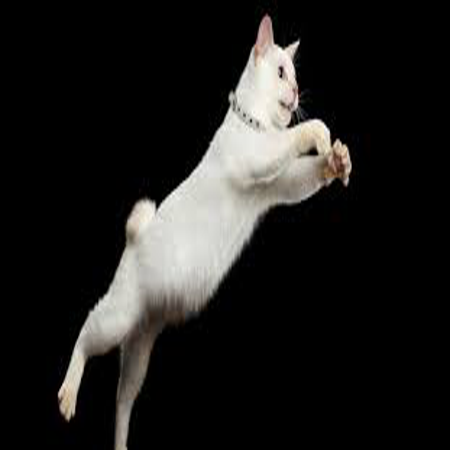

In [ ]:
from PIL import Image
img = Image.open('jumping_cat.jpg')
img = img.resize((450, 450))
img

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as T
from PIL import Image

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = Image.open(image_path)

    trans = T.Compose(
        [
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    image = trans(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(
        k, num_pixels, encoder_dim
    )  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.tensor([[word_map["<start>"]]] * k, dtype=torch.long) # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    #seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    #complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(
            encoder_out, h
        )  # (s, encoder_dim), (s, num_pixels)

        '''
        alpha = alpha.view(
            -1, enc_image_size, enc_image_size
        )  # (s, enc_image_size, enc_image_size)
        '''

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(
            torch.cat([embeddings, awe], dim=1), (h, c)
        )  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        # import pdb; pdb.set_trace()
        seqs = torch.cat(
            [seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1
        )  # (s, step+1)
        #seqs_alpha = torch.cat(
        #    [seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
        #)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [
            ind
            for ind, next_word in enumerate(next_word_inds)
            if next_word != word_map["<end>"]
        ]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            #complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        #seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    #alphas = complete_seqs_alpha[i]

    #return seq, alphas
    return seq

In [ ]:
with torch.no_grad():
    seq = caption_image_beam_search(encoder, decoder, "jumping_cat.jpg", word_map, beam_size=3)
seq

[2631, 1, 7, 3, 4, 5, 13, 9, 10, 2632]

In [ ]:
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
words

'a white dog is running through the snow'